# Synthesising music from a Quantum Cellular Automaton

This tutorial will show you a method of turning the output of a Quantum Cellular Automaton into music. No knowledge of music or quantum cellular automata will be needed, but a little knowledge of music and a little knowledge of quantum circuits will be helpful.

We will be viewing a partitioned quantum cellular automaton (PQCA) as a piece of software that produces $n$ bits every time we ask it to. For us $n$ will always be 12, so an example output from a PQCA will be:

In [1]:
example_twelve_bits = [0,0,0,1,0,0,1,0,1,0,1,1]

We will go through how to turn these 12 bits into music first, and then show how to set up the PQCA.

The packages used in this tutorial are:
 - music21
 - musical-scales
 - pqca
 - qiskit

In [2]:
import music21
import musical_scales
import pqca
import qiskit

music21: Certain music21 functions might need the optional package matplotlib;
                  if you run into errors, install it by following the instructions at
                  http://mit.edu/music21/doc/installing/installAdditional.html


`music21` may be showing a warning about potentially needing `matplotlib` - we will not require this functionality.

## From bits to a chord of notes

We will split this bitstring into four parts.
 - Bit 0 denotes whether this chord will simply be a rest or not
 - Bit 1 denotes whether this chord be long or short
 - Bits 2 and 3 denote the mode
 - Bits 4-11 denote which notes from the scale to play together as a chord

![A breakdown of 12 bits into sections as described above](images/split_12_bits.svg)

An example mode is "A major", and if our bitstring indicated we should play notes 1, 2, and 3 in this mode then our chord would be "A B C#".

We will be using the `musical_scales` package for easy access to these modes and notes.

In [3]:
from musical_scales import scale

Let's break our bitstring up into the sections we declared above.

In [4]:
def bit_breakdown(twelve_bits_long):
    return {"rest": twelve_bits_long[0],
            "long": twelve_bits_long[1],
            "scale": twelve_bits_long[2:4],
            "notes": twelve_bits_long[4:12]
    }

And here's an example of this breakdown in action:

In [5]:
bit_breakdown(example_twelve_bits)

{'rest': 0, 'long': 0, 'scale': [0, 1], 'notes': [0, 0, 1, 0, 1, 0, 1, 1]}

Let's pick some modes for this project. Below we give a function that maps just the `scale` section of bits onto one of 4 modes. The modes we've chosen are inspired by the Axis Of Awesome's song "Four Chords", which are themselves just a specific incarnation of the doo-wop chord progression `I - VIm - IV - V`:
 - E major
 - C# harmonic minor
 - A major
 - B major

In [6]:
modes_to_choose_from = [
    ("E", "major"), ("B", "major"), ("C#", "harmonic minor"), ("A", "major")
]
def bits_to_scale_data(mode_bits, modes = modes_to_choose_from):
    def note_mode_pair_to_object(note_mode_pair):
        note, mode = note_mode_pair
        return {"fundamental": note, "mode": mode}
    
    if mode_bits[0]:
        if mode_bits[1]:
            return note_mode_pair_to_object(modes[0])
        return note_mode_pair_to_object(modes[1])
    if mode_bits[1]:
        return note_mode_pair_to_object(modes[2])
    return note_mode_pair_to_object(modes[3])

This is enough information for someone to sit down and work out the chord on a piano. We want this music to be stored as a MIDI file so our computers can play it for us. We will be using the `music21` package to handle MIDI creation.

In [7]:
def chord_from_bits(bits, note_lengths=["quarter","eighth"]):
    breakdown = bit_breakdown(bits)
    duration = note_lengths[0] if breakdown["long"] else note_lengths[1]
    if breakdown["rest"]:
        this_chord = music21.note.Rest(duration=music21.duration.Duration(duration))
    else:
        scale_data = bits_to_scale_data(breakdown["scale"])
        scale_notes = scale(scale_data["fundamental"], scale_data["mode"])
        list_of_notes = [str(note) for index, note in enumerate(scale_notes)
               if breakdown["notes"][index]]
        this_chord = music21.chord.Chord(list_of_notes)
        this_chord.duration.type = duration
    return this_chord

In [8]:
chord_from_bits(example_twelve_bits)

<music21.chord.Chord E3 G#3 C4 C#4>

### (Non-quantum) example bits

Our first demonstration will use a _classical_ bitstream generator. We will replace this with a partitioned quantum cellular automaton later on.

In [9]:
import random

In [10]:
class Bit_Generator:
    def __next__(self):
        return [random.random() > 0.5 for i in range(0,12)]
BG = Bit_Generator()

This just generates 12 bits as a time each time we call `next(BG)`, with each entry in the sequence having a 50/50 chance of being 0 or 1. With our classical bitstream generator we can generate sequences of chords.

In [11]:
chord_sequence = [chord_from_bits(next(BG)) for i in range(0,20)]

A `stream` is how music21 handles a sequence of chords.

In [12]:
instrumentation = music21.instrument.Vibraphone() # Vibraphone

#instrumentation = music21.instrument.instrumentFromMidiProgram(24) # Acoustic Nylon Guitar
#instrumentation = music21.instrument.Harpsichord() # Harpsichord
def stream_from_chords(chords, instrument=instrumentation):
    stream = music21.stream.Stream()
    stream.insert(0, instrument)
    for chord in chords:
        stream.append(chord)
    return stream

That's all the data we need, so write it to a MIDI file.
    

In [13]:
def save_midi(stream, output_midi_file="temp.midi"):
    stream.write("midi",output_midi_file)

In [14]:
save_midi(stream_from_chords(chord_sequence)) # Saves to "temp.midi" by default

To draw the score we'll need access to `ipython`'s `Image` class:

In [15]:
from IPython.display import Image

In [16]:
def show_score(stream):
    return Image(stream.write("lily.png"))

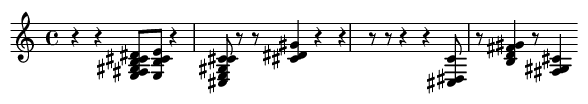

In [17]:
show_score(stream_from_chords(chord_sequence))

Give it a listen! Each chord has a 50/50 chance to be a rest, and each note of the scale has a 50/50 chance to be included in each chord. That's because we used a classical random number generator for each bit. Now let's make it quantum.

# Making it your own

Remember that the entire process of turning bits into chords is given by the functions above. For example you can:
 - Change the modes used by changing the value of `chords_to_choose_from`. See the [musical-scales](https://pypi.org/project/musical-scales/) package for a list of the modes available.
 - Change the timings by changing the `note_lengths` argument in the `chord_from_bits` function. `music21` uses American-style note lengths ("half" rather than "minim", "quarter" rather than "crotchet", etc.)
 - Change the instrument used via the `instrument` variable.
   - Remember you can write `music21.instrument.` and then press `tab` to see a list of options
   - The list of instruments afforded by `music21` is also found in the right hand side of [this page](http://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html)
   - You can also specify a [MIDI program number](http://www.ccarh.org/courses/253/handout/gminstruments/)
       using `music21.instrument.instrumentFromMidiProgram(number-1)`
 - Change any other aspect of how chords are created. All that matters is that we start with 12 bits and end with chords.

# Drawing the states

Many people find it easier to imagine the state of a cellular automaton as a sequence of squares (white for 1, black for 0).
This was discussed a little in the Getting Started tutorial, and we will use similar code here to represent what is going on with our `Bit_Generator`.

In [18]:
import drawSvg
def quilt(bit_generator, number_of_iterations):
    # This code just draws things, understanding it isn't necessary for the tutorial
    square_size = 20 # in pixels
    number_of_bits = 12
    drawing = drawSvg.Drawing(square_size*number_of_bits, square_size*number_of_iterations)
    for iteration in range(number_of_iterations):
        state = next(bit_generator)
        for index, bit in enumerate(state):
            colour = '#eeeeee' if bit else '#000000'
            rect = drawSvg.Rectangle(index*square_size,(number_of_iterations-iteration-1)*square_size,square_size,square_size, fill=colour)
            drawing.append(rect)
    return drawing

Let's call on `BG` 20 times, drawing each result as a new row in the quilt.

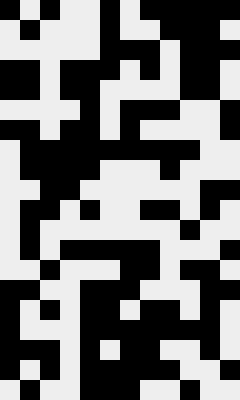

In [19]:
quilt(BG, 20)

# Making it quantum

`pqca` is a module that allows us to easily construct partitioned quantum cellular automata (PQCAs). It is built on top of `qiskit`, so it may be a little slow to load in.

In [20]:
import pqca

We want our PQCA to have 12 qubits, just like our classical bit generator generated sequences of 12 (classical) bits. In this tutorial we are going to partition these 12 qubits into 4 _cells_, each containing 3 qubits.

![A grid of 12 bits split into 4 cells each of width 3](images/12_by_1_split_into_3s.svg)

In [21]:
num_qubits = 12
tessellated_line = pqca.tessellation.one_dimensional(num_qubits,3)

In [22]:
print(tessellated_line)

Tessellation(12 qubits as 4 cells, first cell: [0, 1, 2])


With this partition in place we can specify an update circuit that will be applied to each cell of 3 qubits. Here's an example circuit.

In [23]:
import qiskit
cell_circuit = qiskit.QuantumCircuit(3)
cell_circuit.h(0)
cell_circuit.cx(0,1)
cell_circuit.z(2)
cell_circuit.cx(2,1)
cell_circuit.draw()

┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐┌───┐
q_1: ─────┤ X ├┤ X ├
     ┌───┐└───┘└─┬─┘
q_2: ┤ Z ├───────■──
     └───┘

You don't need to use the circuit we've provided! Play around with this circuit, or see the other tutorials for how to make more complicated update circuits. An Update Frame combines the update circuit we just drew with the tessellation.

In [24]:
update_frame_1 = pqca.UpdateFrame(tessellated_line, qiskit_circuit=cell_circuit)

An automaton has a starting state and way of updating that state. For our automaton we will need to provide:
 - An initial state
 - A list of update frames
 - A circuit simulator
 

We will set our initial states as a 1 followed by eleven 0s. We will be using the Aer qasm simulator provided as part of qiskit. If you have access to a quantum computer, or want a different simulator, see the section on "changing the backend" in the `getting_started` tutorial.

In [25]:
initial_state = [0]*num_qubits
initial_state[0] = 1

That's our initial state done, and we only have one update frame, so let's make the automaton.

In [26]:
automaton = pqca.Automaton(initial_state, [update_frame_1], pqca.backend.qiskit())

An automaton only knows its current state and how to update that state. Here's our starting state:

In [27]:
automaton.state

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

But what will it actually do? Well, the full update circuit can be accessed via `automaton.update_circuit`.

In [28]:
automaton.update_circuit.draw()

┌───┐          
 q_0: ┤ H ├──■───────
      └───┘┌─┴─┐┌───┐
 q_1: ─────┤ X ├┤ X ├
      ┌───┐└───┘└─┬─┘
 q_2: ┤ Z ├───────■──
      ├───┤          
 q_3: ┤ H ├──■───────
      └───┘┌─┴─┐┌───┐
 q_4: ─────┤ X ├┤ X ├
      ┌───┐└───┘└─┬─┘
 q_5: ┤ Z ├───────■──
      ├───┤          
 q_6: ┤ H ├──■───────
      └───┘┌─┴─┐┌───┐
 q_7: ─────┤ X ├┤ X ├
      ┌───┐└───┘└─┬─┘
 q_8: ┤ Z ├───────■──
      ├───┤          
 q_9: ┤ H ├──■───────
      └───┘┌─┴─┐┌───┐
q_10: ─────┤ X ├┤ X ├
      ┌───┐└───┘└─┬─┘
q_11: ┤ Z ├───────■──
      └───┘

The automaton will create a circuit that:
 - Initialises the qubits (based on current state)
 - Applies the update_circuit
 - Measures the qubits

The automaton will then update its state with the newly measured results.

## Actually running it

In [29]:
next(automaton)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]

Just as with the classical bit generator we can draw a quilt of squares, with each row representing a new state of the automaton.

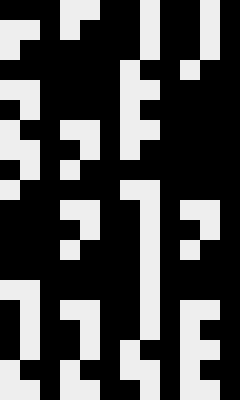

In [30]:
quilt(automaton, 20)

Run that cell a few times, the result depends on the circuit you made earlier. If you used the example circuit we gave you'll spot that the third qubit in each cell is stuck in the `0` state. Try changing the circuit so that this is no longer the case.

Let's use it to make music, just as we did before.

In [31]:
chord_sequence = [chord_from_bits(next(automaton)) for i in range(0,20)]

In [32]:
save_midi(stream_from_chords(chord_sequence), "pqca.midi")

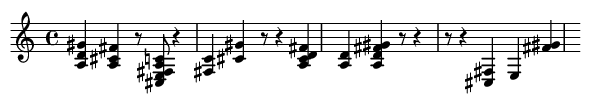

In [33]:
show_score(stream_from_chords(chord_sequence))

If you would rather work with MusicXML than MIDI then you can use the following function to do so, provided you have [MuseScore](https://musescore.org) installed.

In [34]:
def save_musicxml(stream, file="temp.xml"):
    stream.write("musicxml", file)
#save_musicxml(stream_from_chords(chord_sequence)) # requires MuseScore

Give the file `pqca.midi` a listen! That's music synthesised from a quantum cellular automaton. Our first output can be found as `first_pqca.midi`; we actually turned the `rest` functionality off for that one so we could hear every state in the automaton.

That's it, thank you for reading this tutorial!

Detailed documentation can be found at [readthedocs.io](https://partitioned-quantum-cellular-automata.readthedocs.io/en/latest/) as well as in the docstrings of the python files themselves. The pqca module and these tutorials are available under the MIT licence, with source code available at [Hector Miller-Bakewell’s github](https://github.com/hmillerbakewell/partitioned-quantum-cellular-automata). This package was created as part of the [QuTune Project](https://iccmr-quantum.github.io/).